In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
from matplotlib import pyplot as plt

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

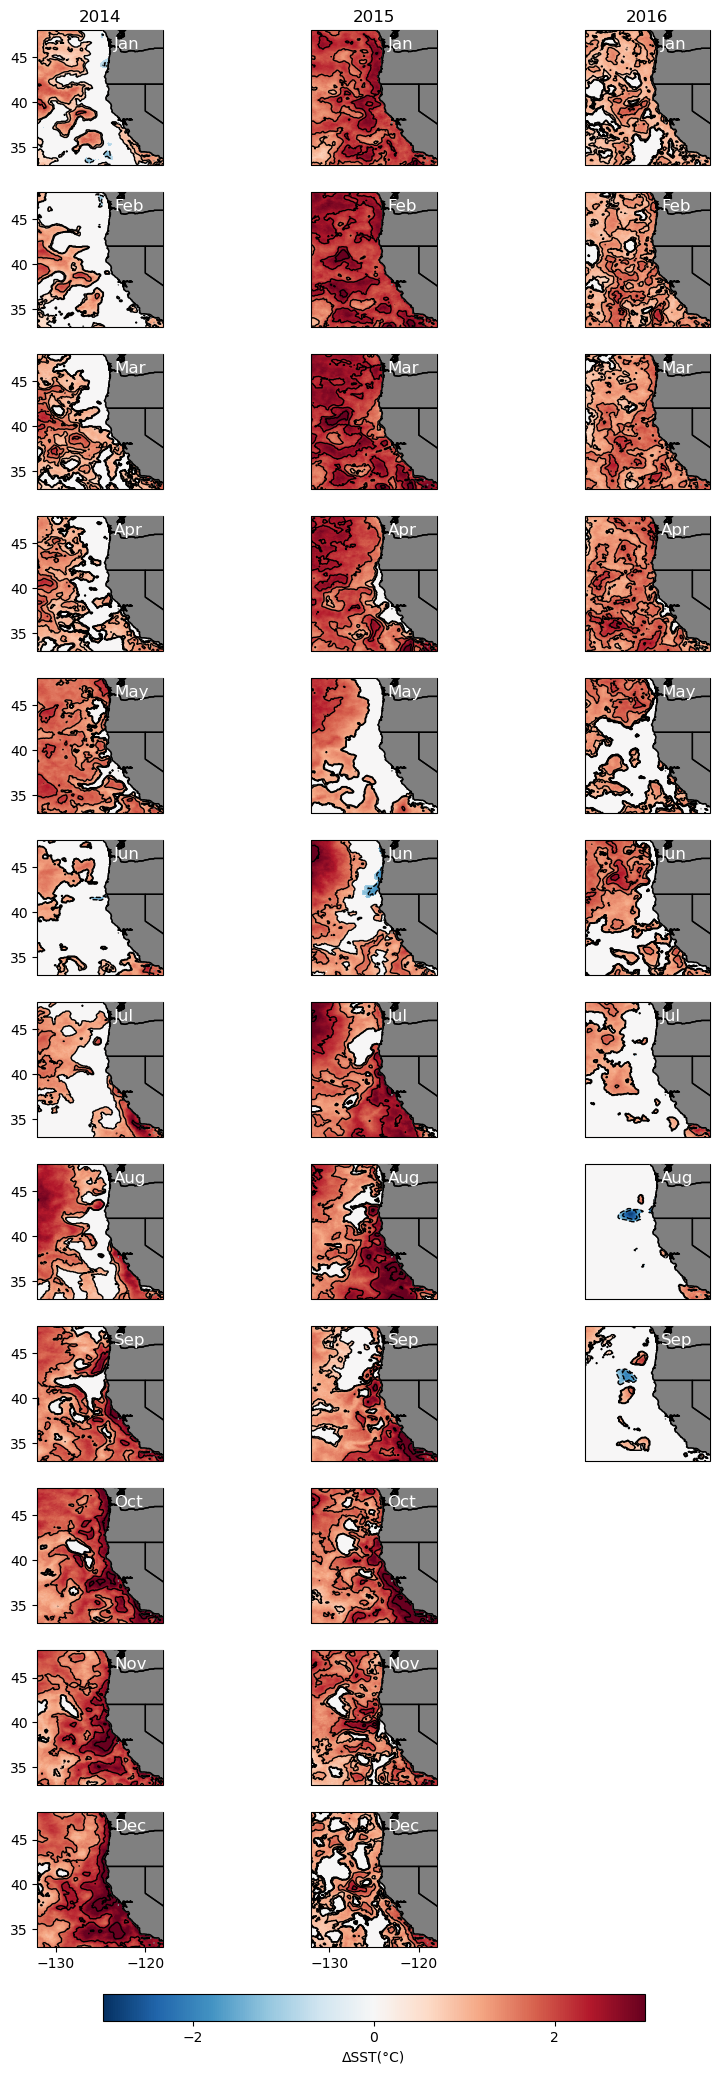

In [4]:
# process data
data = ds.analysed_sst - 273.15
prev = data.sel(time = slice('2002', '2012'))

prev_mean = prev.groupby(prev.time.dt.month).mean()
prev_sd = prev.groupby(prev.time.dt.month).std()

ds_2014 = data.sel(time = slice('2014-01-01', '2014-12-31'))
ds_2015 = data.sel(time = slice('2015-01-01', '2015-12-31'))
ds_2016 = data.sel(time = slice('2016-01-01', '2016-12-31'))


ds_2014m = ds_2014.groupby('time.month').mean()
ds_2015m = ds_2015.groupby('time.month').mean()
ds_2016m = ds_2016.groupby('time.month').mean()

diff_2014 = ds_2014m - prev_mean
diff_2015 = ds_2015m - prev_mean
diff_2016 = ds_2016m - prev_mean

anomaly_2014 = (diff_2014).where(abs(diff_2014/prev_sd) >= 1).fillna(0)
anomaly_2015 = (diff_2015).where(abs(diff_2015/prev_sd) >= 1).fillna(0)
anomaly_2016 = (diff_2016).where(abs(diff_2016/prev_sd) >= 1).fillna(0)


month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
year = [2014, 2015, 2016]

fig, axs = plt.subplots(nrows = 12, ncols = 3, subplot_kw = dict(projection = crs), figsize = (10, 30))


# draw graph
for i in range(3):
    for j in range(12):
        if i == 0:
            data = anomaly_2014
        elif i == 1:
            data = anomaly_2015
        else:
            data = anomaly_2016
        cmap = data.sel(month = j+1).plot(ax = axs[j, i], transform = crs, add_colorbar = False, vmin = -3, vmax = 3, cmap = "RdBu_r", zorder = 1)
        data.sel(month = j+1).plot.contour(ax = axs[j, i], colors = 'black', linewidths = 1, cmin = -3, cmax = 3, zorder=2)
        axs[j, i].coastlines("10m", color = "k", zorder = 3)
        axs[j, i].add_feature(cfeature.LAND, color = "grey", zorder=4)
        axs[j, i].add_feature(cfeature.STATES.with_scale("10m"), zorder=5) 
        axs[j, i].set_title("")
        axs[j, i].text(-123.5, 46, month[j], fontsize = 12, color = 'white', zorder=6)

        if i == 0:
            axs[j, i].set_yticks(range(35, 46, 5))
            axs[j, i].set_ylabel("")
        if j == 0:
            axs[j, i].set_title(year[i])
        if j == 11:
            axs[j, i].set_xticks(range(-130, -119, 10))
            axs[j, i].set_xlabel("")

# add colorbar
colorbar = plt.colorbar(cmap, ax = axs, location = 'bottom', shrink = 0.7, pad = 0.02)
colorbar.set_label('ΔSST(°C)')
colorbar.set_ticks(range(-2,3,2))

# delete last three plots
fig.delaxes(axs[9, 2])
fig.delaxes(axs[10, 2])
fig.delaxes(axs[11, 2])

# save plot
plt.savefig('outputs/hw3_Q04.png')